![](https://camo.githubusercontent.com/d4cf5332e46bfbcecce6737172ce48ff90e3d890f9ef76ff904630a1548b10a1/68747470733a2f2f696d6167652e616a756e6577732e636f6d2f636f6e74656e742f696d6167652f323032312f30312f32352f32303231303132353138313034343432373136372e706e67)

# LSTM을 통한 삼성전자 주가 예측

## LSTM

논문 : [Long Short-term Memory(1997, Neural Computation)](https://www.researchgate.net/publication/13853244_Long_Short-term_Memory)

우리는 현재 시점의 뭔가를 얻기 위해서 멀지 않은 최근의 정보만을 필요로 할 때가 있다. 예를 들어 NLP에서 이전 단어들을 토대로 다음에 올 단어를 예측하는 모델을 만들 때 마지막 단어를 맞추고 싶다면 모든 문장을 볼 필요 없이 시간 격차가 크지 않은 정보만을 활용해도 충분할 것이다.

하지만 반대로 더 많은 문맥을 필요로 하는 경우도 있다. 바로 전에 단어만으로는 문맥을 알 수 없는, 단어가 쓰이게 되는 문맥까지 고려해야 하는 경우일 것이다. 이렇게 되면 필요한 정보를 얻기 위한 시간 격차는 굉장히 커지게 된다.

RNN Layer를 많이 쌓는다면, 항상 최신 정보를 중요하게 학습하기 때문에 학습을 진행할수록 이전 정보를 유지하기가 어렵다. LSTM은 이러한 문제를 해결하는 모델이다.

## LSTM Network

LSTM은 RNN의 한 종류로 긴 의존 기간을 필요로 하는 학습을 수행할 수 있는 능력을 가지고 있다. 이 모델은 긴 의존 기간의 문제를 피하기 위해 명시적으로 설계되었다. 모델의 구조는 아래와 같다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile30.uf.tistory.com%2Fimage%2F999F603E5ACB86A00550F0)

그림에서 보면 알 수 있듯이 LSTM의 반복 모듈에는 4개의 상호작용하는 Layer가 들어있다.
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile5.uf.tistory.com%2Fimage%2F993A93495ACB86A02FFAA8)

## LSTM의 핵심 아이디어

LSTM의 핵심은 Cell State인데, 모듈 그림에서 수평으로 그어진 윗 선에 해당한다. Cell State는 작은 Linear Interaction만을 적용시키면서 전체 체인을 계속 구동시킨다. 정보가 바뀌지 않고 그대로 흐르게하는 것을 매우 쉽게할 수 있다.
![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile10.uf.tistory.com%2Fimage%2F99CB87505ACB86A00FAB6F)

LSTM은 Cell State에 무엇인가를 더하거나 없앨 수 있는 능력이 있는데, 이 능력은 Gate에 의해 제어된다. Gate는 정보가 전달될 수 있도록 하는 추가적인 방법으로, Sigmoid Layer와 Pointwise 곱셉으로 이루어져 있다.

![](https://img1.daumcdn.net/thumb/R1280x0/?scode=mtistory2&fname=http%3A%2F%2Fcfile29.uf.tistory.com%2Fimage%2F99C98C4F5ACB86A01FD4E5)

LSTM은 Sigmoid 함수를 통해 컴포넌트가 정보를 얼마나 전달해야하는지 정한다. 그 값이 0이라면 아무것도 넘기지 않을 것이며, 1이라면 모든 정보를 다음 Layer에 넘길 것이다. Sigmoid 함수와 Pointwise 곱셈을 통해 이전 State의 정보량을 조절하는 것이 LSTM의 핵심 개념이다. 

이제부터 LSTM을 활용하여 시계열 예측을 해보고자 한다.

# Step 0 데이터 수집 : Yahoo Finance 데이터 불러오기

- 우선 삼성전자 주가의 데이터를 Yahoo Finance모듈에서 불러온다. yfinance모듈을 사용했으며 사용시 데이터의 시작지점은 2017년 1월 부터 2022년 01월 20일까지로 설정 해주었다.
- 삼성전자의 Ticker의 경우 구글에 '삼성전자 주가'를 검색후 나오는 코드인 005930에 '.KS'를 추가해주어 '005930.KS'를 넣어 주었다. 이중에서 종가(Close)를 가져와 price라고 지정해주고 분석을 시작하였다.

In [1]:
!pip install yfinance

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf


samsung_df = yf.download('005930.KS',
                      start='2017-01-01',
                      end='2022-01-20',
                      progress=False)
samsung_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-01-02,35980.0,36240.0,35880.0,36100.0,31327.476562,4650600
2017-01-03,36280.0,36620.0,36020.0,36480.0,31657.240234,7357650
2017-01-04,36500.0,36520.0,36100.0,36160.0,31379.539062,7971750
2017-01-05,36060.0,36060.0,35540.0,35560.0,30858.863281,10967450
2017-01-06,36180.0,36440.0,36040.0,36200.0,31414.244141,8880950
...,...,...,...,...,...,...
2022-01-13,79300.0,79300.0,77900.0,77900.0,77900.000000,13889401
2022-01-14,77700.0,78100.0,77100.0,77300.0,77300.000000,10096725
2022-01-17,77600.0,77800.0,76900.0,77500.0,77500.000000,8785122


In [3]:
samsung_df = samsung_df.reset_index()

samsung_df.columns = ['day', 'open', 'high', 'low', 'close', 'adj close', 'volume']

samsung_df['day'] = pd.to_datetime(samsung_df['day'])

samsung_df.index = samsung_df['day']
samsung_df.set_index('day', inplace=True)

samsung_df

,open,high,low,close,adj close,volume
day,,,,,,
2017-01-02,35980.0,36240.0,35880.0,36100.0,31327.476562,4650600
2017-01-03,36280.0,36620.0,36020.0,36480.0,31657.240234,7357650
2017-01-04,36500.0,36520.0,36100.0,36160.0,31379.539062,7971750
2017-01-05,36060.0,36060.0,35540.0,35560.0,30858.863281,10967450
2017-01-06,36180.0,36440.0,36040.0,36200.0,31414.244141,8880950
...,...,...,...,...,...,...
2022-01-13,79300.0,79300.0,77900.0,77900.0,77900.000000,13889401
2022-01-14,77700.0,78100.0,77100.0,77300.0,77300.000000,10096725
2022-01-17,77600.0,77800.0,76900.0,77500.0,77500.000000,8785122


In [4]:
import warnings
warnings.filterwarnings(action='ignore')

# Step 1 EDA : Time Series Data Visualization

우선 삼성전자 주가 데이터를 탐색해보자. 다음 코드로 데이터셋을 살펴보면, 삼성전자 주가 데이터는 총 1239개의 행으로 이루어진 것을 알 수 있다.

또한 데이터는 결측값 없이 날짜와 open, high, low, close, adj close, volume의 6개 피쳐로 구성되어 있다.

먼저 Train/Test set으로 나눌것인데 마지막 날짜 20일을 제외한 나머지를 Train으로 지정 해주고 마지막 날짜 20일을 Test으로 지정 해주었다. 마지막 일주일의 주식 가격을 예측하고자 한다.

In [5]:
samsung_df

,open,high,low,close,adj close,volume
day,,,,,,
2017-01-02,35980.0,36240.0,35880.0,36100.0,31327.476562,4650600
2017-01-03,36280.0,36620.0,36020.0,36480.0,31657.240234,7357650
2017-01-04,36500.0,36520.0,36100.0,36160.0,31379.539062,7971750
2017-01-05,36060.0,36060.0,35540.0,35560.0,30858.863281,10967450
2017-01-06,36180.0,36440.0,36040.0,36200.0,31414.244141,8880950
...,...,...,...,...,...,...
2022-01-13,79300.0,79300.0,77900.0,77900.0,77900.000000,13889401
2022-01-14,77700.0,78100.0,77100.0,77300.0,77300.000000,10096725
2022-01-17,77600.0,77800.0,76900.0,77500.0,77500.000000,8785122


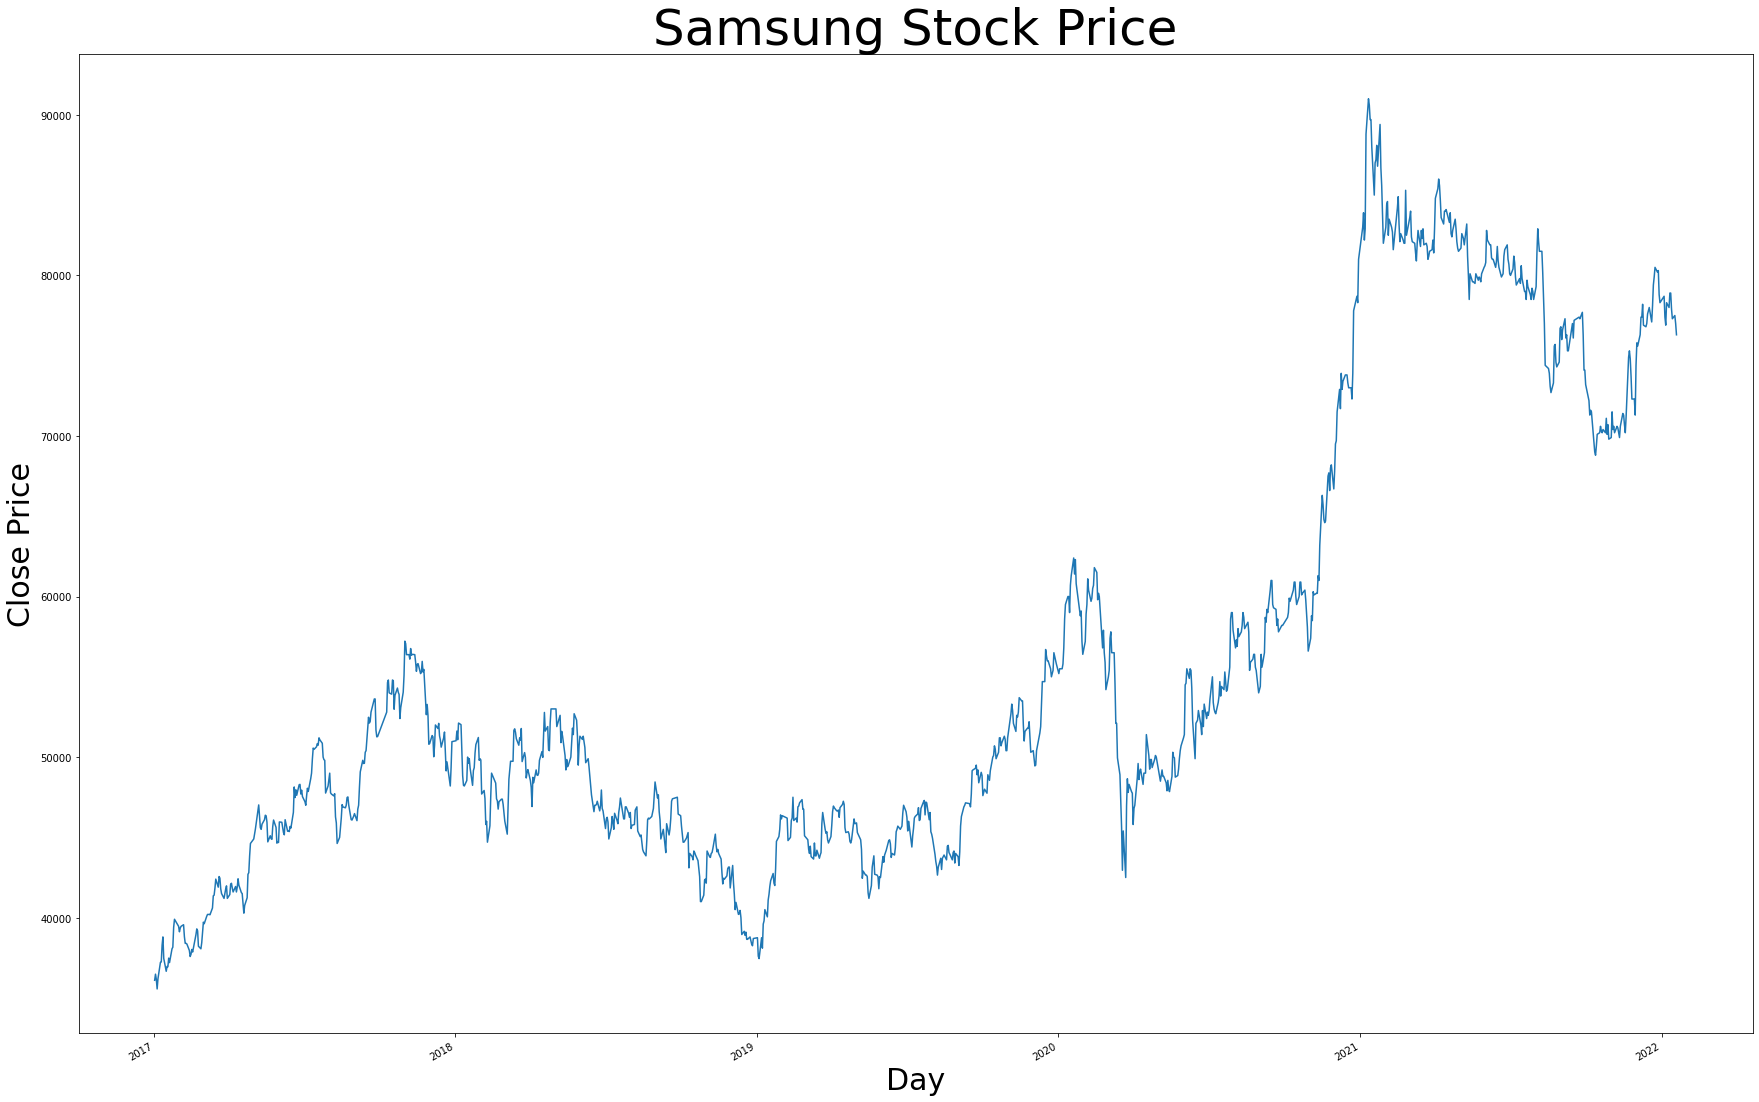

In [6]:
fig, ax = plt.subplots(figsize=(30, 20))
samsung_df['close'].plot(ax=ax)
plt.title("Samsung Stock Price",fontsize=50)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Close Price', fontsize=30)
plt.show()

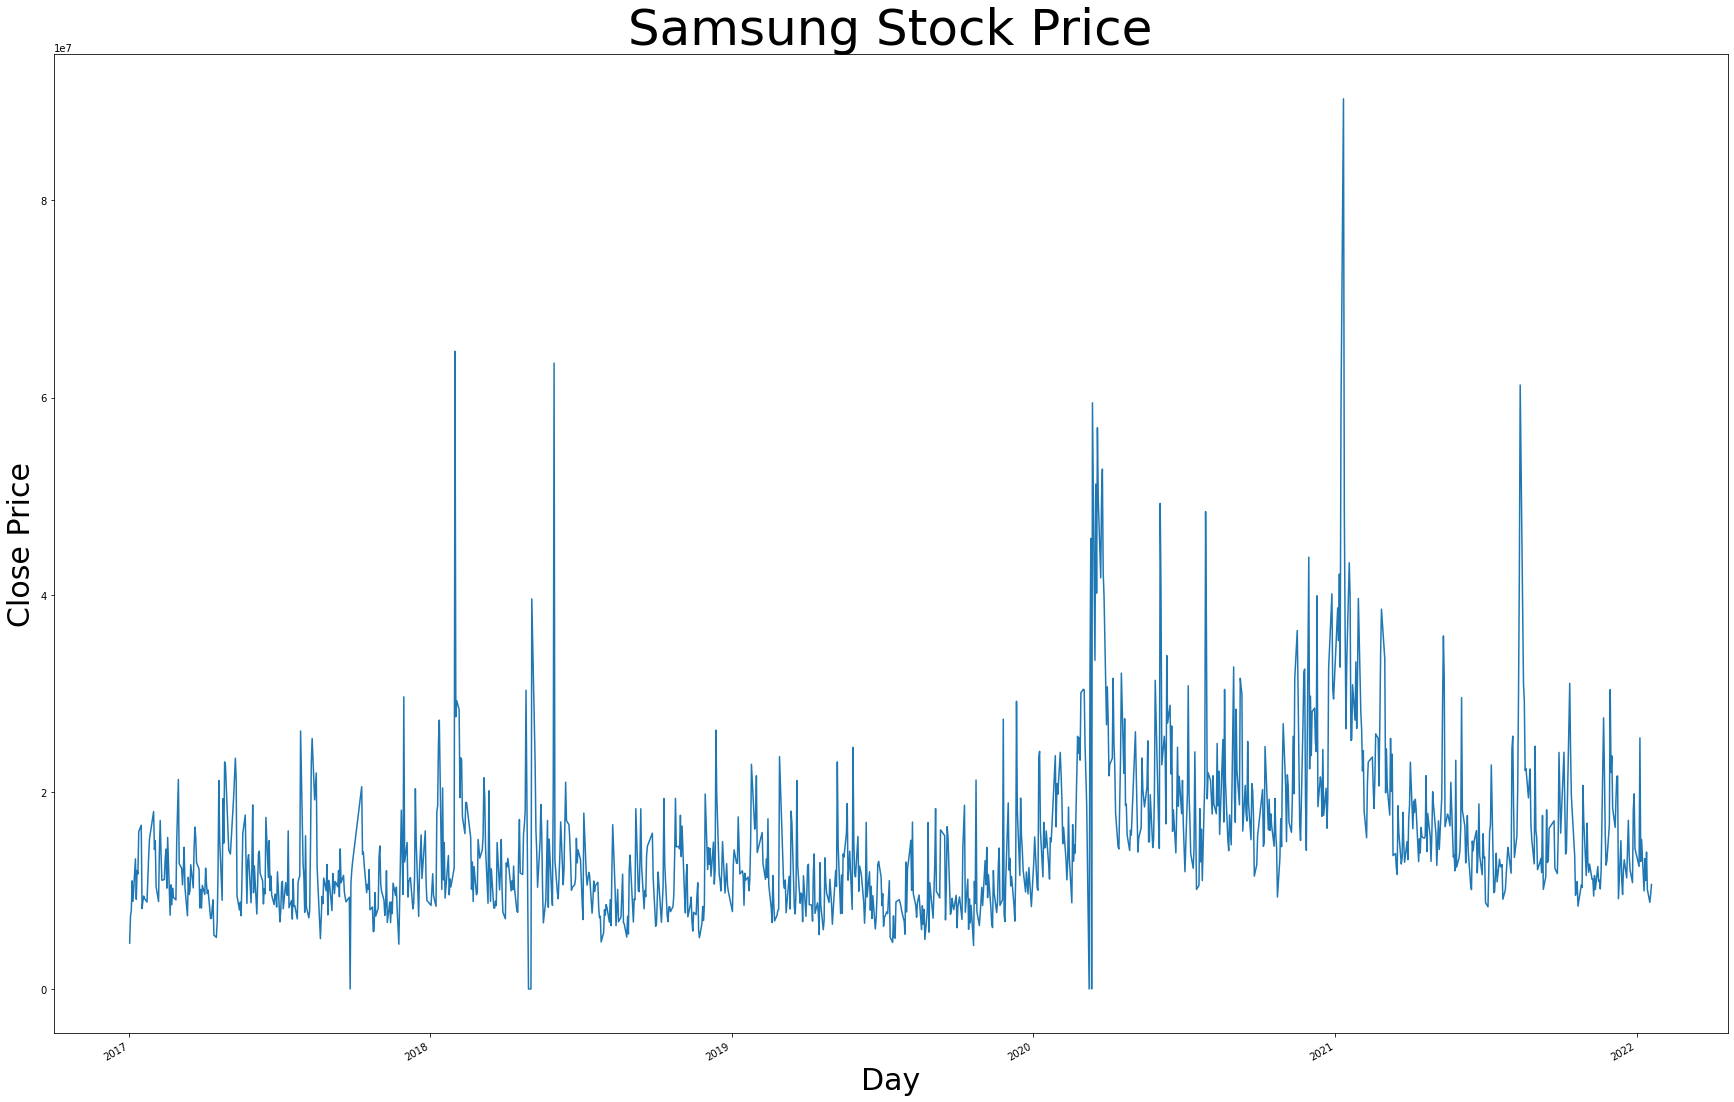

In [7]:
fig, ax = plt.subplots(figsize=(30, 20))
samsung_df['volume'].plot(ax=ax)
plt.title("Samsung Stock Price",fontsize=50)
plt.xlabel('Day', fontsize=30)
plt.ylabel('Close Price', fontsize=30)
plt.show()

# Step 2 Training


## Normalization
딥러닝 모델이 학습을 잘하기 위해서는 정규화의 과정이 필요합니다. sklearn package의 MinMaxScaler를 활용하여 전체 학습 데이터를 정규화해주도록 하겠습니다.

In [8]:
samsung_df.columns

Index(['open', 'high', 'low', 'close', 'adj close', 'volume'], dtype='object')

## Make Dataset

다음으로 학습시킬 데이터셋을 생성해야 합니다. Window Size는 내가 얼마 동안의 주가 데이터에 기반하여 다음날 주가를 예측할 것인자를 정하는 parameter입니다. 즉 내가 과거 20일을 기반으로 내일 데이터를 예측한다고 가정한다면 window_size = 20이 됩니다.

이 프로젝트에서는 과거 30일을 기준으로 그 다음날의 데이터를 예측해보도록 하겠습니다.

Train_size = 1100으로 설정하여, 학습은 전체 데이터 중 앞의  1100일 만큼의 데이터를 학습하게 되고, Test를 위해 뒤의 139일의 데이터로 모델이 주가를 예측하도록 한 후 실제 데이터와 오차가 얼마나 있는지 확인해보도록 하겠습니다.

In [9]:
X = samsung_df.drop(columns='volume') 
print(X)

               open     high      low    close     adj close
day                                                         
2017-01-02  35980.0  36240.0  35880.0  36100.0  31327.476562
2017-01-03  36280.0  36620.0  36020.0  36480.0  31657.240234
2017-01-04  36500.0  36520.0  36100.0  36160.0  31379.539062
2017-01-05  36060.0  36060.0  35540.0  35560.0  30858.863281
2017-01-06  36180.0  36440.0  36040.0  36200.0  31414.244141
...             ...      ...      ...      ...           ...
2022-01-13  79300.0  79300.0  77900.0  77900.0  77900.000000
2022-01-14  77700.0  78100.0  77100.0  77300.0  77300.000000
2022-01-17  77600.0  77800.0  76900.0  77500.0  77500.000000
2022-01-18  77600.0  77800.0  76600.0  77000.0  77000.000000
2022-01-19  76500.0  76900.0  76100.0  76300.0  76300.000000

[1239 rows x 5 columns]


In [10]:
y = samsung_df.iloc[:, 4:5]
print(y)

               adj close
day                     
2017-01-02  31327.476562
2017-01-03  31657.240234
2017-01-04  31379.539062
2017-01-05  30858.863281
2017-01-06  31414.244141
...                  ...
2022-01-13  77900.000000
2022-01-14  77300.000000
2022-01-17  77500.000000
2022-01-18  77000.000000
2022-01-19  76300.000000

[1239 rows x 1 columns]


In [11]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 

mm = MinMaxScaler() 
ss = StandardScaler() 
X_ss = ss.fit_transform(X) 
y_mm = mm.fit_transform(y)

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda:0 is available


Time Series Data의 경우 시간 순서가 매우 중요하기 때문에 shuffle은 꼭 False로 하셔야 합니다.

In [13]:
# Train Data 
X_train = X_ss[:1100, :] 
X_test = X_ss[1100:, :] 

# Test Data 
y_train = y_mm[:1100, :] 
y_test = y_mm[1100:, :] 
print("Training Shape", X_train.shape, y_train.shape) 
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (1100, 5) (1100, 1)
Testing Shape (139, 5) (139, 1)


In [14]:
from torch.autograd import Variable 
from torch.utils.data import Dataset, DataLoader

In [15]:
X_train_tensors = Variable(torch.Tensor(X_train)) 
X_test_tensors = Variable(torch.Tensor(X_test)) 

y_train_tensors = Variable(torch.Tensor(y_train)) 
y_test_tensors = Variable(torch.Tensor(y_test)) 

X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], 1, X_train_tensors.shape[1])) 
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], 1, X_test_tensors.shape[1])) 

print("Training Shape", X_train_tensors_final.shape, y_train_tensors.shape) 
print("Testing Shape", X_test_tensors_final.shape, y_test_tensors.shape)

Training Shape torch.Size([1100, 1, 5]) torch.Size([1100, 1])
Testing Shape torch.Size([139, 1, 5]) torch.Size([139, 1])


# Step 3 Model Implementation

In [16]:
class LSTM1(nn.Module): 
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length): 
        super(LSTM1, self).__init__() 
        self.num_classes = num_classes #number of classes 
        self.num_layers = num_layers #number of layers 
        self.input_size = input_size #input size 
        self.hidden_size = hidden_size #hidden state 
        self.seq_length = seq_length #sequence length 
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, 
                            num_layers=num_layers, batch_first=True) #lstm 
        self.fc_1 = nn.Linear(hidden_size, 128) #fully connected 1 
        self.fc = nn.Linear(128, num_classes) #fully connected last layer 
        self.relu = nn.ReLU() 
        
    def forward(self,x): 
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state 
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state 
        # Propagate input through LSTM 
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state 
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next 
        out = self.relu(hn) 
        out = self.fc_1(out) #first Dense 
        out = self.relu(out) #relu 
        out = self.fc(out) #Final Output 
        
        return out

## Parameter & Hyperparameter Setting

In [17]:
num_epochs = 30000 #1000 epochs
learning_rate = 0.0001 #0.001 lr

input_size = 5 #number of features
hidden_size = 2 #number of features in hidden state
num_layers = 1 #number of stacked lstm layers

num_classes = 1 #number of output classes 
lstm1 = LSTM1(num_classes, input_size, hidden_size, num_layers, X_train_tensors_final.shape[1]).to(device)

## Loss Function
loss_function = torch.nn.MSELoss()    # mean-squared error for regression

optimizer = torch.optim.Adam(lstm1.parameters(), lr=learning_rate)  # adam optimizer

## Training

In [18]:
for epoch in range(num_epochs): 
    outputs = lstm1.forward(X_train_tensors_final.to(device)) #forward pass 
    optimizer.zero_grad() #caluclate the gradient, manually setting to 0 
    
    # obtain the loss function 
    loss = loss_function(outputs, y_train_tensors.to(device)) 
    
    loss.backward() #calculates the loss of the loss function 
    
    optimizer.step() #improve from loss, i.e backprop 
    
    if epoch % 100 == 0: 
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.05497
Epoch: 100, loss: 0.04329
Epoch: 200, loss: 0.02879
Epoch: 300, loss: 0.01653
Epoch: 400, loss: 0.00899
Epoch: 500, loss: 0.00551
Epoch: 600, loss: 0.00431
Epoch: 700, loss: 0.00389
Epoch: 800, loss: 0.00363
Epoch: 900, loss: 0.00338
Epoch: 1000, loss: 0.00314
Epoch: 1100, loss: 0.00291
Epoch: 1200, loss: 0.00267
Epoch: 1300, loss: 0.00243
Epoch: 1400, loss: 0.00221
Epoch: 1500, loss: 0.00201
Epoch: 1600, loss: 0.00183
Epoch: 1700, loss: 0.00164
Epoch: 1800, loss: 0.00147
Epoch: 1900, loss: 0.00132
Epoch: 2000, loss: 0.00121
Epoch: 2100, loss: 0.00111
Epoch: 2200, loss: 0.00105
Epoch: 2300, loss: 0.00100
Epoch: 2400, loss: 0.00096
Epoch: 2500, loss: 0.00093
Epoch: 2600, loss: 0.00091
Epoch: 2700, loss: 0.00089
Epoch: 2800, loss: 0.00087
Epoch: 2900, loss: 0.00085
Epoch: 3000, loss: 0.00083
Epoch: 3100, loss: 0.00081
Epoch: 3200, loss: 0.00079
Epoch: 3300, loss: 0.00078
Epoch: 3400, loss: 0.00076
Epoch: 3500, loss: 0.00074
Epoch: 3600, loss: 0.00073
Epoch: 3700, 

# Step 4 Prediction

In [19]:
df_X_ss = ss.transform(samsung_df.drop(columns='volume'))
df_y_mm = mm.transform(samsung_df.iloc[:, 4:5])

df_X_ss = Variable(torch.Tensor(df_X_ss)) #converting to Tensors
df_y_mm = Variable(torch.Tensor(df_y_mm))

#reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], 1, df_X_ss.shape[1]))
train_predict = lstm1(df_X_ss.to(device))#forward pass
data_predict = train_predict.data.detach().cpu().numpy() #numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) #reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)

In [20]:
data_predict[1100:]

array([[80161.91 ],
       [79871.13 ],
       [79341.46 ],
       [79277.96 ],
       [79674.88 ],
       [80468.91 ],
       [80015.86 ],
       [79149.12 ],
       [78746.76 ],
       [78945.17 ],
       [79072.13 ],
       [78817.64 ],
       [79871.13 ],
       [79072.13 ],
       [78343.01 ],
       [78343.01 ],
       [77825.09 ],
       [79010.336],
       [78609.97 ],
       [78152.516],
       [77883.49 ],
       [78609.97 ],
       [78343.01 ],
       [77825.09 ],
       [78609.97 ],
       [80631.4  ],
       [82243.76 ],
       [81237.6  ],
       [80706.38 ],
       [80780.24 ],
       [79412.51 ],
       [77883.49 ],
       [76465.03 ],
       [73875.93 ],
       [73678.33 ],
       [73421.29 ],
       [72556.21 ],
       [72154.28 ],
       [72748.74 ],
       [75039.86 ],
       [75236.41 ],
       [74085.164],
       [73787.414],
       [74114.516],
       [76132.47 ],
       [76293.625],
       [75469.97 ],
       [76068.41 ],
       [76753.05 ],
       [75570.39 ],


In [21]:
dataY_plot[1100:]

array([[80254.336],
       [79957.1  ],
       [79362.625],
       [79263.55 ],
       [79659.87 ],
       [80452.5  ],
       [80056.18 ],
       [79164.47 ],
       [78669.07 ],
       [78966.3  ],
       [79065.39 ],
       [78768.16 ],
       [79858.03 ],
       [79065.39 ],
       [78272.75 ],
       [78272.75 ],
       [77777.35 ],
       [78966.3  ],
       [78569.99 ],
       [78074.59 ],
       [77777.35 ],
       [78470.914],
       [78272.75 ],
       [77777.35 ],
       [78569.99 ],
       [80650.66 ],
       [82136.85 ],
       [81344.21 ],
       [80749.74 ],
       [80749.74 ],
       [79461.7  ],
       [77777.35 ],
       [76291.164],
       [73715.09 ],
       [73516.94 ],
       [73219.695],
       [72427.06 ],
       [72030.74 ],
       [72625.22 ],
       [74904.05 ],
       [75003.13 ],
       [73913.26 ],
       [73616.02 ],
       [73913.26 ],
       [75993.93 ],
       [76093.   ],
       [75300.375],
       [75894.84 ],
       [76588.41 ],
       [75399.45 ],


In [22]:
import math
from math import sqrt
from sklearn.metrics import mean_squared_error

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(dataY_plot[:1100], data_predict[:1100]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(dataY_plot[1100:], data_predict[1100:]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 51.89 RMSE
Test Score: 118.93 RMSE


RMSE Score 결과는 위와 같았습니다.
주가가 만원 단위라고 생각했을 때, Score가 나쁘지 않음을 확인할 수 있습니다.

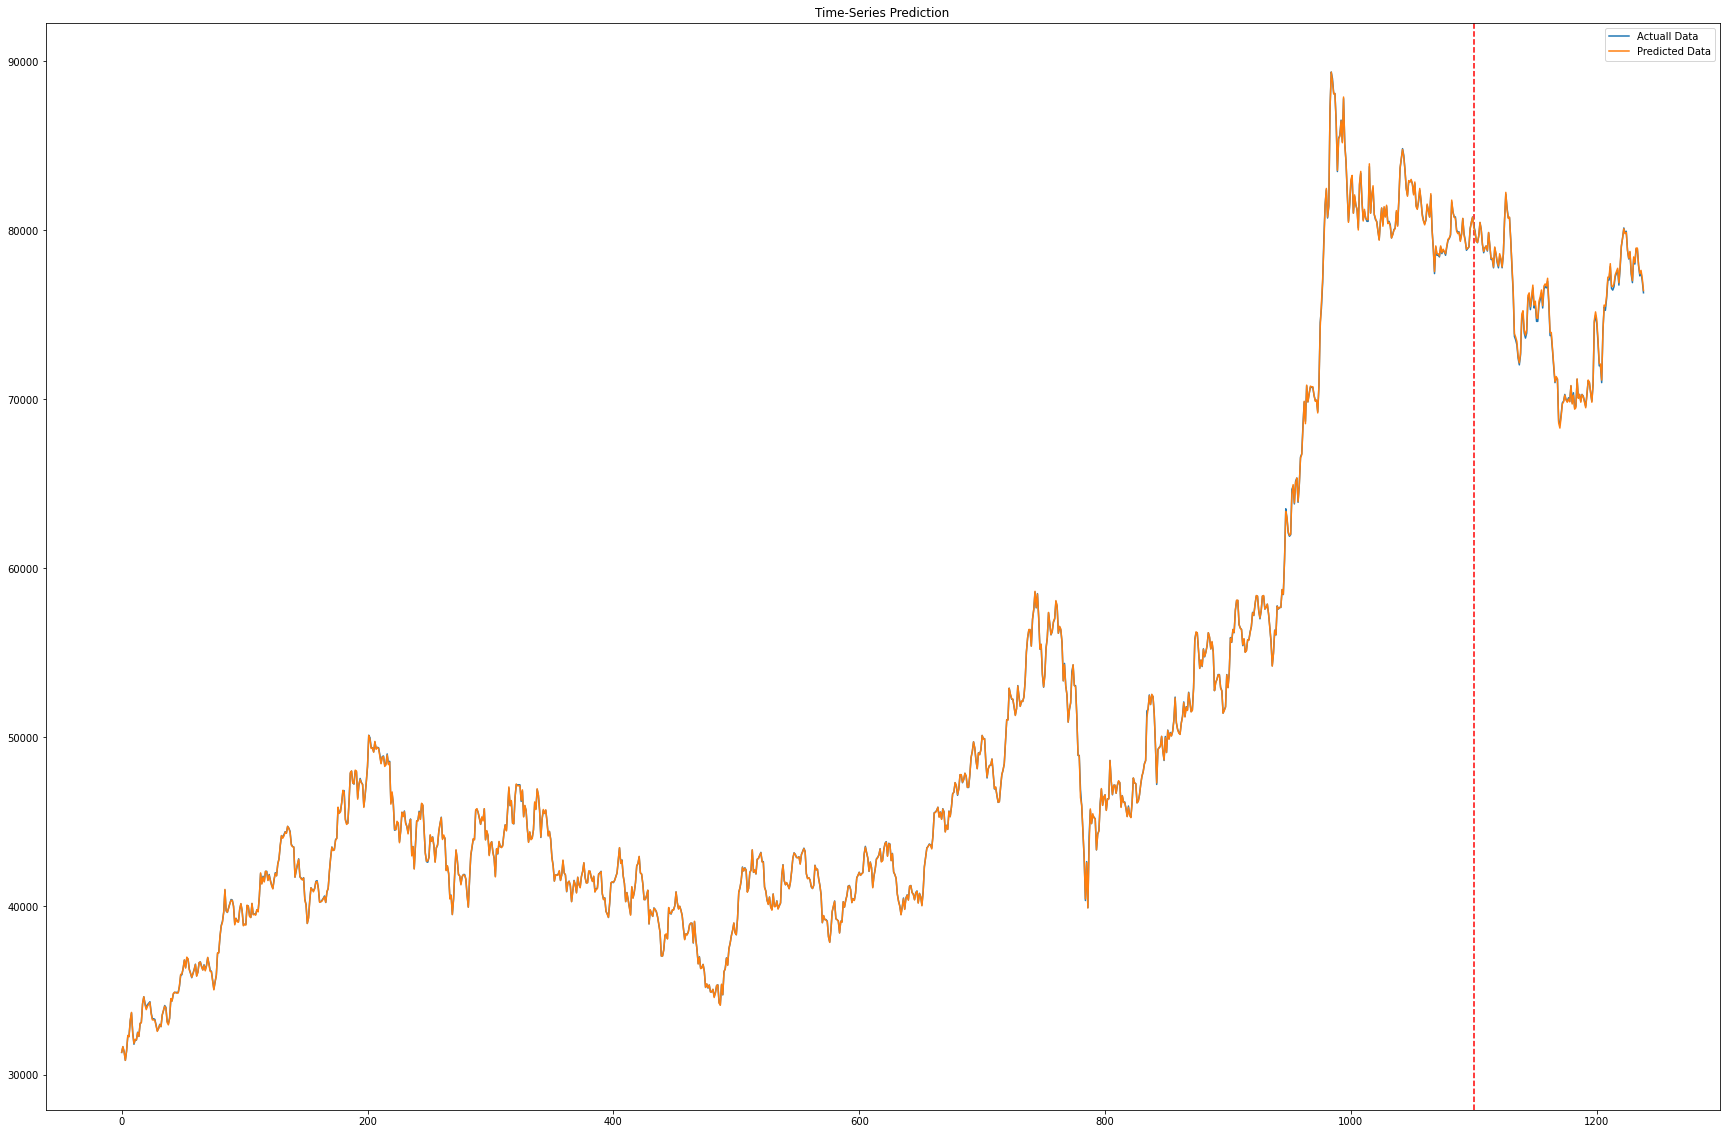

In [23]:
plt.figure(figsize=(30,20)) #plotting
plt.axvline(x=1100, c='r', linestyle='--') #size of the training set

plt.plot(dataY_plot, label='Actuall Data') #actual plot
plt.plot(data_predict, label='Predicted Data') #predicted plot
plt.title('Time-Series Prediction')
plt.legend()
plt.show() 

빨간 선 이후부터 모델이 예측을 한 것인데 나름 비슷하게 나온 것을 확인할 수 있습니다.

급등과 급락 패턴을 어느정도 예측하였음을 알 수 있습니다.